# How to train your DragoNN tutorial 4: 
## Interpreting predictive sequence features in in-vivo TF binding events

This tutorial is a supplement to the DragoNN manuscript and follows figure 8 in the manuscript. 

This tutorial will take 2 - 3 hours if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>Input data</a></li>
    <li><a href=#2>Generating positive and negative bins for genome-wide training </a></li>
    <li><a href=#3>Challenges of in vivo data : batch generators and class upsampling </a></li>
    <li><a href=#4>Case 1: Negatives consist of shuffled references, single-tasked models</a></li>  
    <li><a href=#5>Case 2: Whole-genome negatives, single-tasked models </a></li>
    <li><a href=#6>Case 3: Whole-genome negatives, multi-tasked models </a></li>
    <li><a href=#7>Case 4: What happens if we don't upsample positive examples in our batches? </a></li>
    <li><a href=#8>Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT </a></li>
    <li><a href=#9>Conclusions</a></li>    
</ol>
Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.


In [1]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install https://github.com/kundajelab/simdna/archive/0.3.zip
#!pip install https://github.com/kundajelab/dragonn/archive/keras_2.2_tensorflow_1.6_purekeras.zip

In [2]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

In [3]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from dragonn.tutorial_utils import *

Using TensorFlow backend.
/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Input data <a name='1'>
<a href=#outline>Home</a>

Tutorials 1 - 3 have used simulated data generated with the simdna package. In this tutorial, we will examine how well CNN's are able to predict transcription factor binding for four TF's in vivo. 

We will learn to predict transcription factor binding for four transcription factors in the GM12878 cell line (one of the Tier 1 cell lines for the ENCODE project). First, we download the narrowPeak bed files for each of these transcription factors. You can skip the following code block if you already have the data downloaded. 

In [ ]:
## CTCF, optimal IDR thresholded peaks, Stam Lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000DRZ/
!wget https://www.encodeproject.org/files/ENCFF473RXY/@@download/ENCFF473RXY.bed.gz 

## SPI1, optimal IDR thresholded peaks, Myers lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BGQ/
!wget https://www.encodeproject.org/files/ENCFF002CHQ/@@download/ENCFF002CHQ.bed.gz
    
## ZNF143, optimal IDR thresholded peaks, Snyder lab, hg19
#https://www.encodeproject.org/experiments/ENCSR936XTK/
!wget https://www.encodeproject.org/files/ENCFF544NXC/@@download/ENCFF544NXC.bed.gz

## SIX5, optimal IDR thresholded peaks, Myers Lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BJE/
!wget https://www.encodeproject.org/files/ENCFF606WUV/@@download/ENCFF606WUV.bed.gz

## Download the hg19 chromsizes file (We only use chroms 1 -22, X, Y for training)
!wget https://github.com/kundajelab/dragonn/blob/keras_2.2_tensorflow_1.6_purekeras/paper_supplement/hg19.chrom.sizes
    
## Download the hg19 fasta reference genome (and corresponding .fai index)
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.fai 


## Generating positive and negative bins for genome-wide training <a name='2'>
<a href=#outline>Home</a>

We will use the *genomewide_labels* function from the  [seqdataloader](https://github.com/kundajelab/seqdataloader) package to generate positive and negative labels for the TF-ChIPseq peaks across the genome. We will treat each sample as a task for the model and compare the performance of the model on SPI1 task in the single-tasked and multi-tasked setting.

In [4]:
from seqdataloader import * 

In [5]:
## seqdataloader accepts an input file, which we call tasks.tsv, with task names in column 1 and the corresponding
## peak files in column 2 
!cat tasks.tsv 

SPI1	ENCFF002CHQ.bed.gz	
CTCF	ENCFF473RXY.bed.gz	
ZNF143	ENCFF544NXC.bed.gz	
SIX5	ENCFF606WUV.bed.gz	


With the parameter configuration below, seqdataloader splits the genome into 1kb regions, with a stride of 50. Each 1kb region is centered at a 200 bp bin, with a left flank of 400 bases and a right flank of 400 bases. 

* Each 200 bp bin is labeled as positive if a narrowPeak summit overlaps with it. 

* The bin is labeled ambiguous (label = -1) and excluded from training if there is some overlap with the narrowPeak, but the peak summit does not lie in that overlap. 

* The bin is labeled negative if there is no overlap with the narrowPeak. 

In [ ]:
#we will include all chromosomes with the exception of 1,2, and 19 in our training set 

#1) Generate genome-wide negatives in addition to positives 
train_set_params={
    'task_list':"tasks.tsv",
    'outf':"TF.train.tsv.gz",
    'output_type':'gzip',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(train_set_params)

#2) Extract positive bins for each task for DeepBind training paradigm -- shuffled reference negatives to be 
#generated on the fly 

positives_train_set_params={
    'store_positives_only':True,
    'task_list':"tasks.tsv",
    'outf':"positives.TF.train.tsv.gz",
    'output_type':'gzip',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(positives_train_set_params)

In [ ]:
#We will include chromsoome 1 in our validation set 

#1) Generate genome-wide negatives in addition to positives 
valid_set_params={'task_list':"tasks.tsv",
    'outf':"TF.valid.tsv.gz",
    'output_type':'gzip',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(valid_set_params)


#2) Extract positive bins for each task for DeepBind training paradigm -- shuffled reference negatives to be 
#generated on the fly 
positives_valid_set_params={
    'store_positives_only':True,
    'task_list':"tasks.tsv",
    'outf':"positives.TF.valid.tsv.gz",
    'output_type':'gzip',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(positives_valid_set_params)


In [ ]:
#We will include chromosomes 2 and 19 in our testing set 
test_set_params={
    'task_list':"tasks.tsv",
    'outf':"TF.test.tsv.gz",
    'output_type':'gzip',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(test_set_params)

#2) Extract positive bins for each task for DeepBind training paradigm -- shuffled reference negatives to be 
#generated on the fly 
positives_test_set_params={
    'store_positives_only':True,
    'task_list':"tasks.tsv",
    'outf':"positives.TF.test.tsv.gz",
    'output_type':'gzip',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(positives_test_set_params)


Let's examine the files that were generated: 

In [6]:
#The code generates bed file outputs with a label of 1,0, or -1 (ambiguous, not to be used for training) for each 1kb
# genome bin for each task. Note that the bins are shifted with a stride of 50.
!zcat TF.train.tsv.gz| head -n20

CHR	START	END	SPI1	CTCF	ZNF143	SIX5
chr3	0	1000	0.0	0.0	0.0	0.0
chr3	50	1050	0.0	0.0	0.0	0.0
chr3	100	1100	0.0	0.0	0.0	0.0
chr3	150	1150	0.0	0.0	0.0	0.0
chr3	200	1200	0.0	0.0	0.0	0.0
chr3	250	1250	0.0	0.0	0.0	0.0
chr3	300	1300	0.0	0.0	0.0	0.0
chr3	350	1350	0.0	0.0	0.0	0.0
chr3	400	1400	0.0	0.0	0.0	0.0
chr3	450	1450	0.0	0.0	0.0	0.0
chr3	500	1500	0.0	0.0	0.0	0.0
chr3	550	1550	0.0	0.0	0.0	0.0
chr3	600	1600	0.0	0.0	0.0	0.0
chr3	650	1650	0.0	0.0	0.0	0.0
chr3	700	1700	0.0	0.0	0.0	0.0
chr3	750	1750	0.0	0.0	0.0	0.0
chr3	800	1800	0.0	0.0	0.0	0.0
chr3	850	1850	0.0	0.0	0.0	0.0
chr3	900	1900	0.0	0.0	0.0	0.0

gzip: stdout: Broken pipe


In [7]:
# When provided with the --store-positives_only flag, the code generates all bins for each task that are labeled positive.
!zcat SPI1.positives.TF.train.tsv.gz | head -n20

CHR	START	END	SPI1
chr3	260350	261350	1.0
chr3	260400	261400	1.0
chr3	260450	261450	1.0
chr3	260500	261500	1.0
chr3	319150	320150	1.0
chr3	319200	320200	1.0
chr3	319250	320250	1.0
chr3	319300	320300	1.0
chr3	320050	321050	1.0
chr3	320100	321100	1.0
chr3	320150	321150	1.0
chr3	320200	321200	1.0
chr3	331250	332250	1.0
chr3	331300	332300	1.0
chr3	331350	332350	1.0
chr3	331400	332400	1.0
chr3	505600	506600	1.0
chr3	505650	506650	1.0
chr3	505700	506700	1.0

gzip: stdout: Broken pipe


In [8]:
#We load our test set labels into memory here, as we will use them to measure performance in cases 1 - 4 below.
#Note that we only load the labels into memory, not the actual test dataset. 

#It is not necessary to load the training/validation dataset or labels, see below. 

test_set=pd.read_csv("TF.test.tsv.gz",header=0,sep='\t',index_col=[0,1,2])
print(test_set.shape)

(6046528, 4)


## Challenges of in vivo data : batch generators and class upsampling <a name='3'>
<a href=#outline>Home</a>

In tutorials 1 - 3, we used the [keras fit](https://keras.io/models/sequential/#fit) function to train a CNN. However, when working with real data we face two new challenges: 

1) The dataset is much bigger. In our training set, there are 50,881,560 1kb bins, in our validation set, there are 4,984,994 bins, and in our test set there are 6,046,529 bins. Loading this dataset into memory to pass as a numpy array to the CNN code will require more memory than is available on many machines. Consequently, we use the [keras fit_generator](https://keras.io/models/sequential/#fit_generator) function to limit the memory footprint. This function reads in one batch of training and one batch of validation data at a time from a python generator. in *dragonn.generators*, we provide several python generator functions to match the scenarios below. 

In [9]:
from dragonn.generators import * 

2) The dataset is highly imbalanced. Of the 50,881,560 1kb bins in the training set, only 

* 136,279 are labeled positive for the SPI1 task (372 negatives: 1 positive )

* 131,245 are labeled positive for the CTCF task (387 negatives: 1 positive ) 

* 93,981 are labeled positive for the ZNF143 task (540 negatives: 1 positive ) 

* 15,641 are labeled positive for the SIX5 task (3252 negatives: 1 positive ) 

The class imbalance is far too high for the model to learn unassisted. Hence, we upsample the positive bins to include in each batch with the "upsample" argument to data_generator. The upsample argument accepts a fraction between 0 and 1 and ensures that this fraction of the batch consists of positive bins. 


In [10]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')

In [11]:
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
def initialize_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=(1,1000,4)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(1,35)))

    model.add(Conv2D(filters=15,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=15,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(ntasks))
    model.add(Activation("sigmoid"))

    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam',loss='binary_crossentropy',
                  metrics=[tpr,
                           tnr,
                           fpr,
                           fnr,
                           precision,
                           f1])
    return model

## Case 1: Negatives consist of shuffled references, single-tasked models<a name='4'>
<a href=#outline>Home</a>

We begin by training a model on the SPI1 and CTCF dataset with the following specifications: 

* We use dinucleotide-shuffled positive bins as the negative set. 

* Each batch contains one-hot encoded 1kb regions from the genome, as well as the one-hot-encoded reverse complement sequences of those regions. 

* We ensure that at least 10% of the samples in each batch are positives 

We create generators for the training and validation data to meet these specifications: 

In [12]:
#create the generators
from dragonn.generators import * 
case1_spi1_train_gen=DataGenerator("SPI1.positives.TF.train.tsv.gz","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False)
case1_spi1_valid_gen=DataGenerator("SPI1.positives.TF.valid.tsv.gz","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False)
case1_ctcf_train_gen=DataGenerator("CTCF.positives.TF.train.tsv.gz","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False)
case1_ctcf_valid_gen=DataGenerator("CTCF.positives.TF.valid.tsv.gz","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False)

We now follow the standard protocol we used in tutorials 1 - 3 to train a keras model, with the exception that we use the fit_generator function in keras, rather than the fit function.

In [ ]:
#Train the SPI1 model 
case1_spi1_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case1_spi1=case1_spi1_model.fit_generator(case1_spi1_train_gen,
                                                  validation_data=case1_spi1_valid_gen,
                                                  steps_per_epoch=1000,
                                                  validation_steps=1000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3),History()])

In [ ]:
#Train the CTCF model 
case1_ctcf_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case1_ctcf=case1_ctcf_model.fit_generator(case1_ctcf_train_gen,
                                                  validation_data=case1_ctcf_valid_gen,
                                                  steps_per_epoch=1000,
                                                  validation_steps=1000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3),History()])

In [ ]:
## Plot the learning curves for SPI1  
from dragonn.tutorial_utils import plot_learning_curve
plot_learning_curve(history_case1_spi1)

In [ ]:
## Plot the learning curve for CTCF 
plot_learning_curve(history_case1_ctcf)

We now measure how well the models performed by calculating performance metrics on the test splits across the whole genome. 

In [ ]:
case1_spi1_test_gen=DataGenerator("TF.test.tsv.gz",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['SPI1'])
case1_spi1_test_predictions=case1_spi1_model.predict_generator(case1_spi1_test_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)


In [ ]:
case1_ctcf_test_gen=DataGenerator("TF.test.tsv.gz",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['CTCF'])
case1_ctcf_test_predictions=case1_ctcf_model.predict_generator(case1_ctcf_test_gen,max_queue_size=5000, workers=40, use_multiprocessing=True, verbose=1)


In [48]:
#format true & predicted test labels for performance assessment 

#if test_set.shape is not a multiple of batch_size, 
#there may be some extra values in test_set that need to get truncated.
spi1_test_truth=np.expand_dims(test_set['SPI1'][0:case1_spi1_test_predictions.shape[0]],1).astype(bool)

NameError: name 'case1_spi1_test_predictions' is not defined

In [49]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
from dragonn.metrics import ClassificationResult
print(ClassificationResult(spi1_test_truth,case1_spi1_test_predictions))

NameError: name 'spi1_test_truth' is not defined

In [50]:
ctcf_test_truth=np.expand_dims(test_set['CTCF'][0:case1_ctcf_test_predictions.shape[0]],1).astype(bool)

NameError: name 'case1_ctcf_test_predictions' is not defined

In [ ]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(ctcf_test_truth,case1_ctcf_test_predictions))

## Case 2: Whole-genome negatives, single-tasked models <a name='5'>
<a href=#outline>Home</a>

In [38]:
#create the generators
from dragonn.generators import * 
case2_spi1_train_gen=DataGenerator("TF.train.tsv.gz","hg19.genome.fa.gz",tasks=["SPI1"],upsample_ratio=0.1)
case2_spi1_valid_gen=DataGenerator("TF.valid.tsv.gz","hg19.genome.fa.gz",tasks=["SPI1"],upsample_ratio=0.1)
case2_ctcf_train_gen=DataGenerator("TF.train.tsv.gz","hg19.genome.fa.gz",tasks=["CTCF"],upsample_ratio=0.1)
case2_ctcf_valid_gen=DataGenerator("TF.valid.tsv.gz","hg19.genome.fa.gz",tasks=["CTCF"],upsample_ratio=0.1)


In [39]:
#Train the SPI1 model 
case2_spi1_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case2_spi1=case2_spi1_model.fit_generator(case2_spi1_train_gen,
                                                  validation_data=case2_spi1_valid_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=10000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3),History()])

Epoch 1/150
10000/10000 [==============================] - 215s 22ms/step - loss: 0.2103 - sensitivity: 0.3120 - specificity: 0.9844 - fpr: 0.0156 - fnr: 0.6880 - precision: nan - f1: nan - val_loss: 0.1577 - val_sensitivity: 0.5178 - val_specificity: 0.9846 - val_fpr: 0.0154 - val_fnr: 0.4822 - val_precision: nan - val_f1: nan
Epoch 2/150
10000/10000 [==============================] - 195s 19ms/step - loss: 0.1686 - sensitivity: 0.4944 - specificity: 0.9812 - fpr: 0.0188 - fnr: 0.5056 - precision: nan - f1: nan - val_loss: 0.1440 - val_sensitivity: 0.5160 - val_specificity: 0.9875 - val_fpr: 0.0125 - val_fnr: 0.4840 - val_precision: nan - val_f1: nan
Epoch 3/150
10000/10000 [==============================] - 195s 20ms/step - loss: 0.1636 - sensitivity: 0.5140 - specificity: 0.9810 - fpr: 0.0190 - fnr: 0.4860 - precision: 0.7539 - f1: nan - val_loss: 0.1435 - val_sensitivity: 0.5229 - val_specificity: 0.9879 - val_fpr: 0.0121 - val_fnr: 0.4771 - val_precision: nan - val_f1: nan
Epoch 4

In [40]:
#Train the CTCF model 
case2_ctcf_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case2_ctcf=case2_ctcf_model.fit_generator(case2_ctcf_train_gen,
                                                  validation_data=case2_ctcf_valid_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=10000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3),History()])

Epoch 1/150
10000/10000 [==============================] - 210s 21ms/step - loss: 0.1677 - sensitivity: 0.4932 - specificity: 0.9831 - fpr: 0.0169 - fnr: 0.5068 - precision: nan - f1: nan - val_loss: 0.1220 - val_sensitivity: 0.6444 - val_specificity: 0.9878 - val_fpr: 0.0122 - val_fnr: 0.3556 - val_precision: nan - val_f1: nan
Epoch 2/150
10000/10000 [==============================] - 190s 19ms/step - loss: 0.1288 - sensitivity: 0.6418 - specificity: 0.9840 - fpr: 0.0160 - fnr: 0.3582 - precision: 0.8207 - f1: 0.7059 - val_loss: 0.1214 - val_sensitivity: 0.6008 - val_specificity: 0.9912 - val_fpr: 0.0088 - val_fnr: 0.3992 - val_precision: nan - val_f1: nan
Epoch 3/150
10000/10000 [==============================] - 190s 19ms/step - loss: 0.1252 - sensitivity: 0.6521 - specificity: 0.9842 - fpr: 0.0158 - fnr: 0.3479 - precision: nan - f1: nan - val_loss: 0.1186 - val_sensitivity: 0.5905 - val_specificity: 0.9927 - val_fpr: 0.0073 - val_fnr: 0.4095 - val_precision: nan - val_f1: nan
Epoc

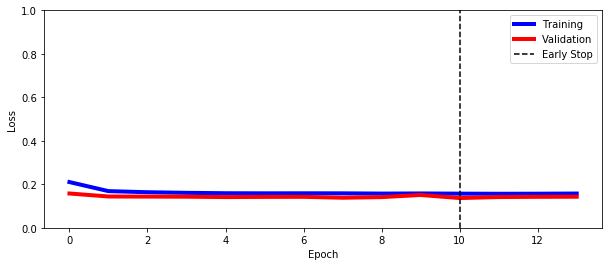

In [41]:
## Plot the learning curves for SPI1  
plot_learning_curve(history_case2_spi1)

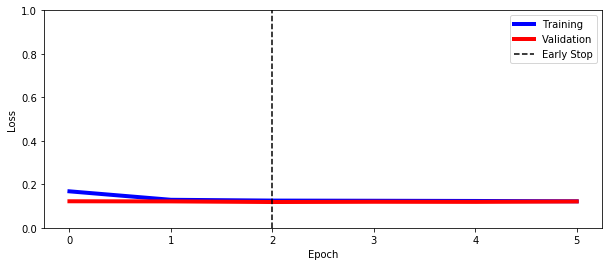

In [42]:
## Plot the learning curves for CTCF  
plot_learning_curve(history_case2_ctcf)

In [44]:
#Get model predictions on the test set 
case2_spi1_test_gen=DataGenerator("TF.test.tsv.gz",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['SPI1'])
case2_spi1_test_predictions=case2_spi1_model.predict_generator(case2_spi1_test_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)


6046/6046 [==============================] - 326s 54ms/step


In [43]:
case2_ctcf_test_gen=DataGenerator("TF.test.tsv.gz",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['CTCF'])
case2_ctcf_test_predictions=case2_ctcf_model.predict_generator(case2_ctcf_test_gen,max_queue_size=5000, workers=40, use_multiprocessing=True, verbose=1)


6046/6046 [==============================] - 329s 54ms/step


In [46]:
from dragonn.metrics import ClassificationResult
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(spi1_test_truth,case2_spi1_test_predictions))

NameError: name 'spi1_test_truth' is not defined

In [47]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(ctcf_test_truth,case2_ctcf_test_predictions))

NameError: name 'ctcf_test_truth' is not defined

## Case 3: Whole-genome negatives, multi-tasked models <a name='6'>
<a href=#outline>Home</a>

In [ ]:
#create the generators for multi-tasked models. Guarantee 10% positives in each batch 
case3_train_gen=data_generator("TF.train.tsv.gz","hg19.genome.fa.gz",upsample_ratio=0.1)
case3_valid_gen=data_generator("TF.valid.tsv.gz","hg19.genome.fa.gz",upsample_ratio=0.1)

In [ ]:
#Train the SPI1 model 
case3_model=initialize_model(4)

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case3=case3_model.fit_generator(case3_train_gen,
                                        validation_data=case3_valid_gen,
                                        steps_per_epoch=1000,
                                        validation_steps=1000,
                                        epochs=10,
                                        verbose=1,
                                        callbacks=[EarlyStopping(patience=3),History()])

In [ ]:
## Plot the learning curves for the multi-tasked model   
plot_learning_curve(history_case3)

In [ ]:
#We  use a custom batch_predict function to generate predictions on the test set, one batch at a time 
case3_predictions,case3_test_truth=dragonn.utils.predict("TF.test.tsv.gz","hg19.genome.fa.gz",case3_model,batch_size=1000000)

## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(case3_test_truth,case3_test_predictions))


## Case 4: What happens if we don't upsample positive examples in our batches? <a name='7'>
<a href=#outline>Home</a>

In [ ]:
#create the generators
case4_spi1_train_gen=data_generator("TF.train.tsv.gz","hg19.genome.fa.gz",tasks=["SPI1"],upsample=False)
case4_spi1_valid_gen=data_generator("TF.valid.tsv.gz","hg19.genome.fa.gz",tasks=["SPI1"],upsample=False)

In [ ]:
#Train the SPI1 model 
case4_spi1_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case4_spi1=case4_spi1_model.fit_generator(case4_spi1_train_gen,
                                                  validation_data=case4_spi1_valid_gen,
                                                  steps_per_epoch=1000,
                                                  validation_steps=1000,
                                                  epochs=10,
                                                  verbose=1,
                                                  callbacks=[EarlyStopping(patience=3),History()])

In [ ]:
## Plot the learning curves for SPI1  
plot_learning_curve(history_case4_spi1)

In [ ]:
#We  use a custom batch_predict function to generate predictions on the test set, one batch at a time 
case4_spi1_test_predictions,case4_spi1_test_truth=dragonn.utils.predict("TF.test.tsv.gz","hg19.genome.fa.gz",case4_spi1_model,tasks=['SPI1'],batch_size=1000000)

## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(case4_spi1_test_truth,case4_spi1_test_predictions))


## Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT <a name='8'>
<a href=#outline>Home</a>


## Conclusions <a name='9'>
<a href=#outline>Home</a>